In [61]:
IMAGES = list()
for img in os.listdir('fin_images'):
    img_path = os.path.join('fin_images', img)
    image = Image.open(img_path)
    IMAGES.append(image)

# FinCogNitioN

## Introduction

The classification of cetacean species has posed a considerable challenge due to their vast morphological and ecological diversity. The present project aimed to categorize 30 species of whales and dolphins by examining the dorsal fin as it protrudes out of the water. It is worth noting that, akin to the human fingerprint, the dorsal fin of cetaceans is unique and can be used to identify individual cetacean species $^{[1]}$. The HappyWhale $^{[2]}$  dataset from Kaggle was utilized to train our models, providing us with three primary pieces of information: an image of the fin in the sea, the cetacean species, and individual IDs. More than one model was implemented to monitor our progress and evaluate the obtained outcomes. Our best algorithm developed entirely from scratch, achieved an accuracy of $x$, a test loss of $y$, and an average F1 score of $z$. Additionally, we attempted to fine-tune a VGG-16 model, resulting in an accuracy of $x$, a test loss of $y$, and an average F1 score of $z$. Our main hurdle was the dataset’s imbalanced nature, with the class possessing the most samples containing $x$ individuals, while the class with the fewest samples had only $y$ individuals. Despite this impediment, we were able to attain satisfactory results, thereby confirming our hypothesis that individual cetacean species can be discerned via analysis of their dorsal fin.

In [82]:
#import used libraries
import seaborn as sns
import os
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
from PIL import Image
from torch import optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from glob import glob
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import numpy as np
from torchvision.transforms import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from numpy import *
from tqdm import tqdm

def plot_batch(IMAGES, num_images=16):
    # Create a figure with 4 rows and 4 columns
    fig, axes = plt.subplots(4, 4, figsize=(15, 10))

    
    # Plot images from the dataloader on each subplot
    k = 0
    for i, _ in enumerate(IMAGES):
        for j in range(4):
            if i * 4 + j >= num_images:
                break

            ax = axes[i, j]
            ax.imshow(IMAGES[k])  # Permute dimensions for proper image display
            k += 1
            ax.set_title(f'Image n°{i * 4 + j + 1} of shape {IMAGES[k].size}')
            ax.axis('off')

        if (i + 1) * 4 >= num_images:
            break

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the figure
    plt.show()

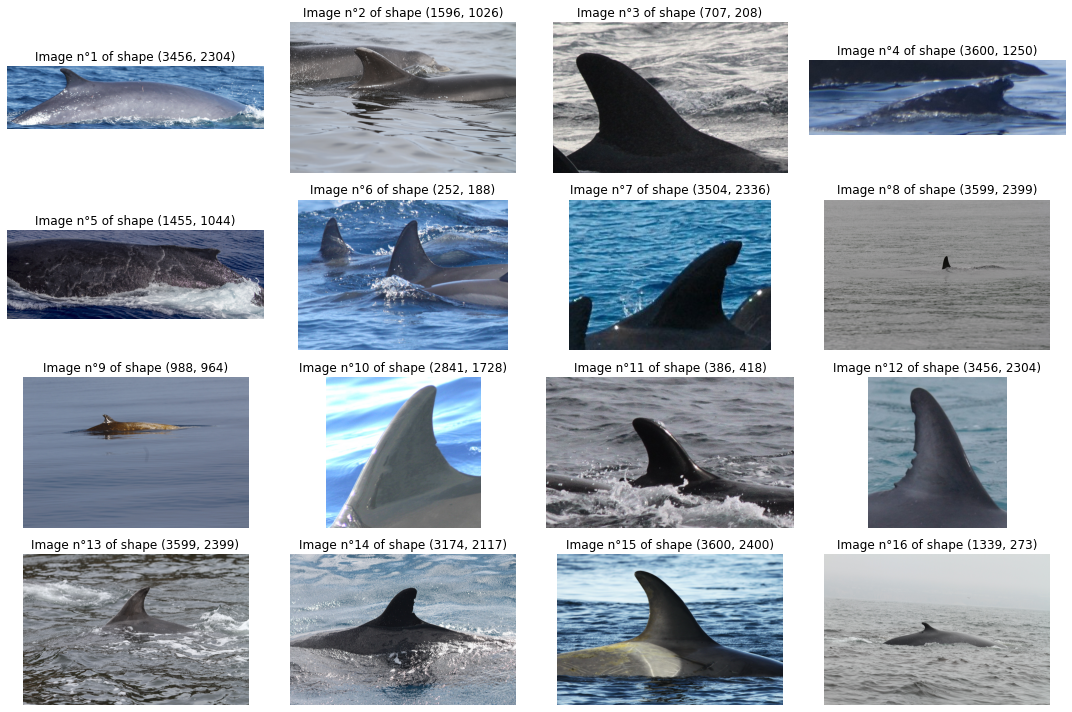

In [83]:
plot_batch(IMAGES)

## Dataset

The present research utilized the HappyWhale Kaggle dataset, boasting a substantial 62.06 GB in size and comprising 50,133 images of cetaceans, each annotated with the respective species and individual IDs. Of note, this dataset is compiled from a collection of over 15,000 individual marine mammals belonging to 30 distinct species, obtained via 28 diverse research organizations. The integration of such data from a range of sources presented various logistical hurdles, such as discrepancies in image size and varied representations of both RGB and grayscale formats.

In [34]:
df = pd.read_csv('train.csv')
df['species'] = df['species'].astype('category').cat.codes

In [35]:
categories = df['species'].value_counts().index
n_samples = df['species'].value_counts().values

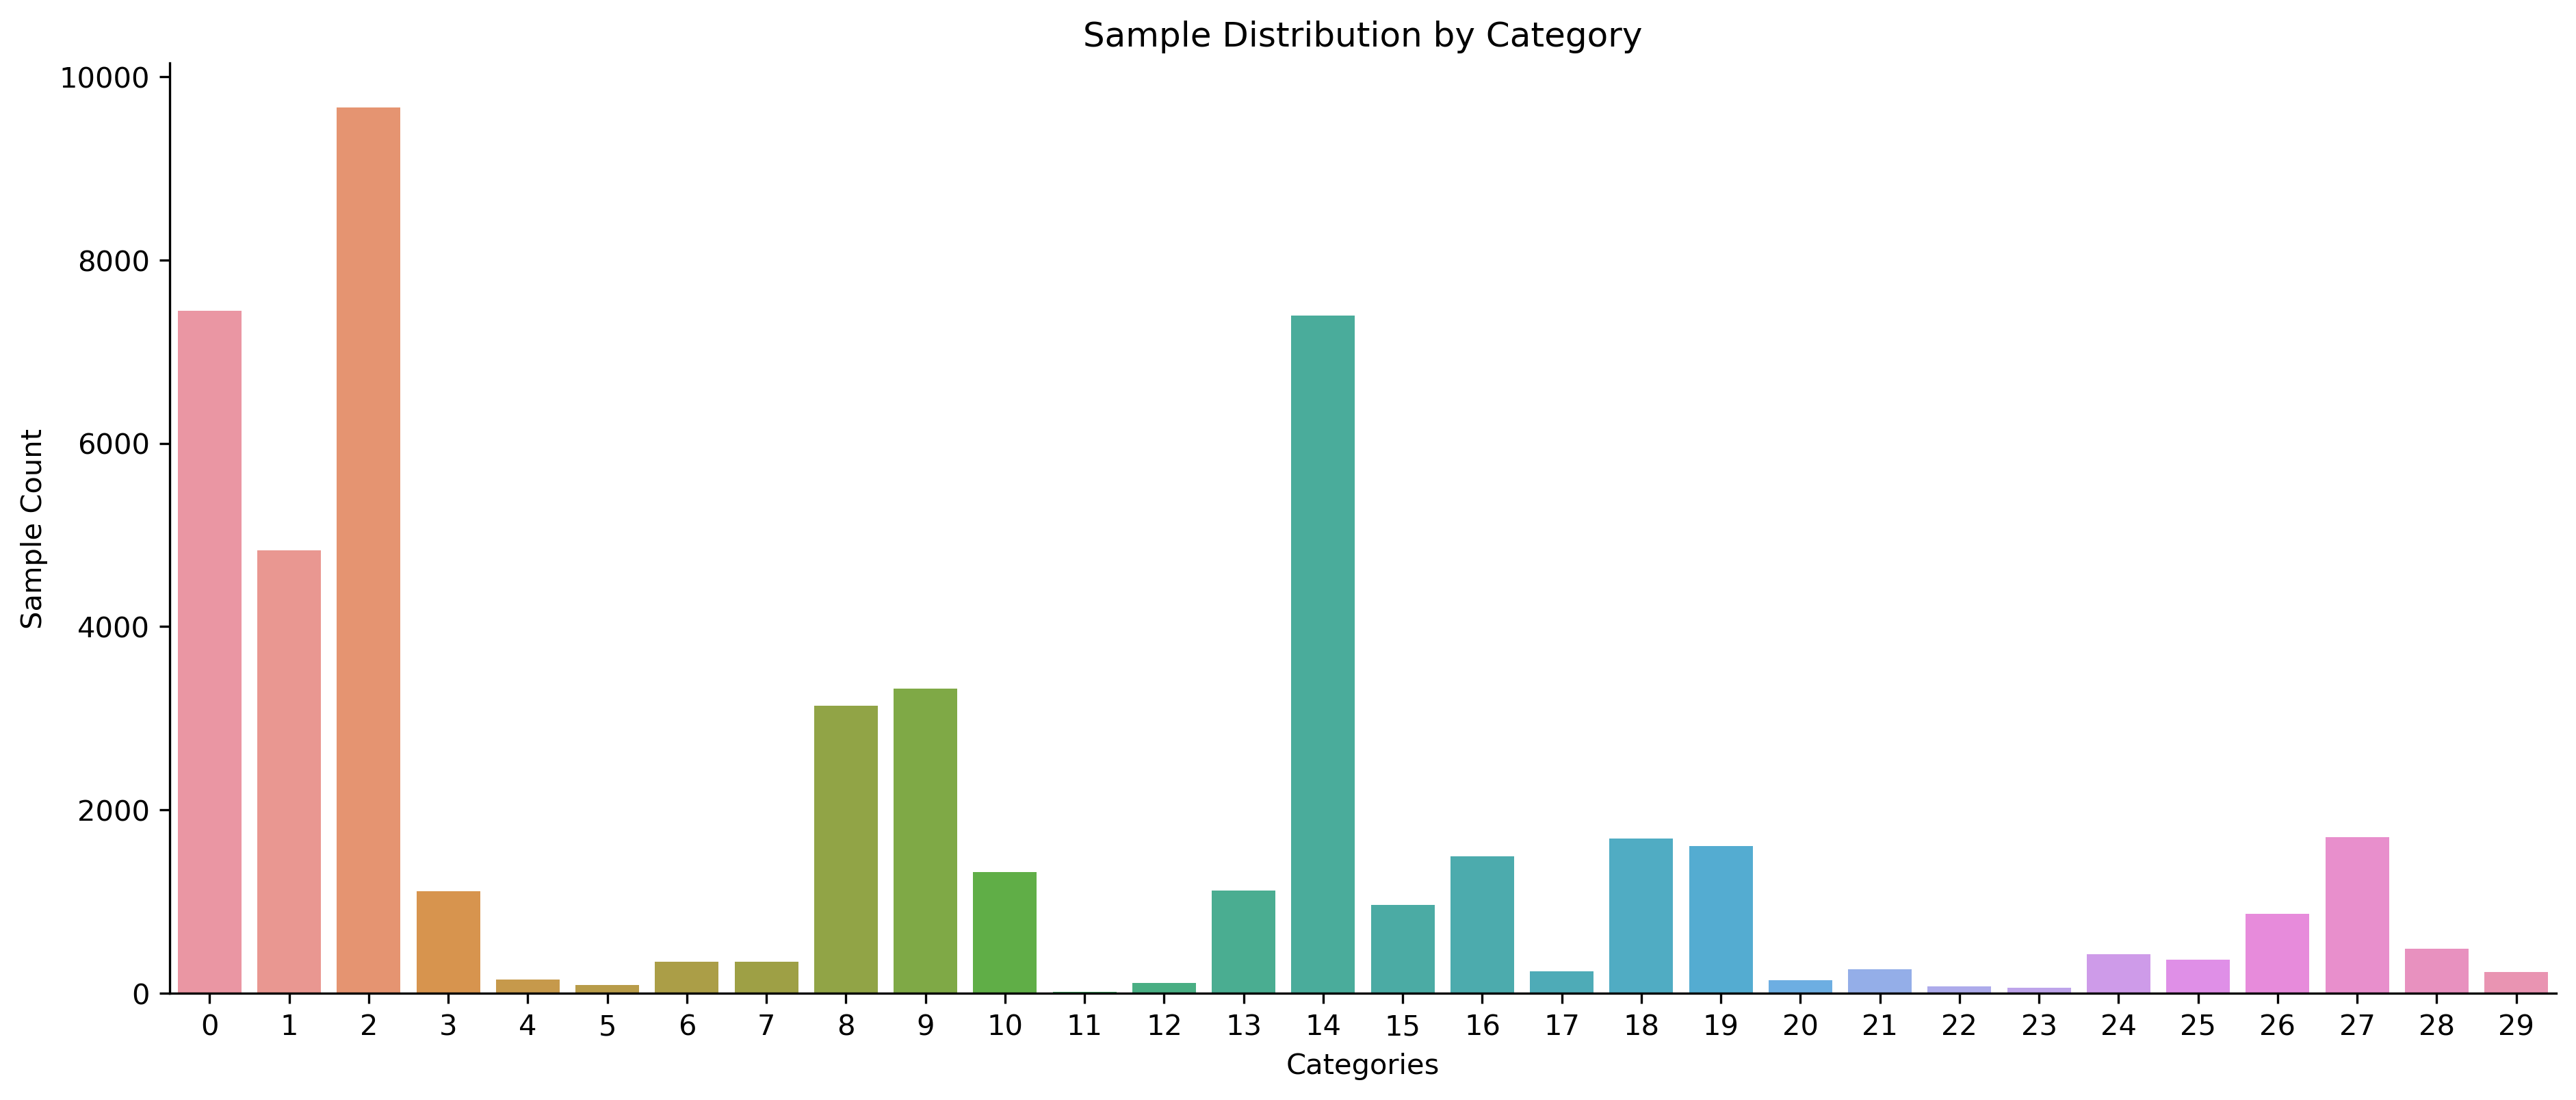

In [53]:
# Create the figure
fig, ax = plt.subplots(figsize=(15, 6), dpi=300)

# Plot the countplot using Seaborn
sns.barplot(x=categories, y=n_samples, ax=ax)

# Set the title and labels
ax.set_title('Sample Distribution by Category')
ax.set_xlabel('Categories')
ax.set_ylabel('Sample Count')

# Customize the appearance
sns.despine()

# Show the plot
plt.show()

In [ ]:
#Load Dataset previously preprocessed in slices in a Colab file aside. We will still report the preprocessing applied in the next cells
data0 = torch.load('0_to_15k.pt')
data1 = torch.load('firstslice.pt')
data2 = torch.load('from_40.pt')
data3 = torch.load('21_31.pt')
data4 = torch.load('31_41.pt')

In [ ]:
#concatenate the slices of the dataset
DATA = torch.utils.data.ConcatDataset([data0, data1, data2, data3, data4])


## Data Preprocessing

In order to preprocess our dataset effectively, we had to conduct an analysis of its distribution to determine the appropriate model definition. During this phase, two major challenges were encountered, namely dataset imbalance and image standardization. 

#### Image Standardization
Initially, we converted the species values in the dataset into numerical values to enhance statistical analysis. This revealed the issues regarding **dataset imbalance**, but we decided to deal with this issue after solving the **image standardization** issue.

About the last mentioned issue, we employed the _pytorch.Transform_   function to resize the images to $224 \times224$  dimensions and then we turned each of them into a vector to make it processable by the rest of the nertowrk. As for the channel sizing issue, initially, we experimented with the _Grayscale_ transform, but realized that forcing the channels to $1$ would create unnecessary challenges for the fin recognition while forcing them to $3$ would have made our network uselessly heavier, since the grayscaled images would have had $3$ channels with the same value in each of them. Eventually, we resolved this issue by using _Image.convert(‘RGB’)_  when loading the images in the Dataset object to maintain the original number of channels in each image. 

Since there are no random transformations applied to our dataset. We decided to preprocess our data all at once in a separate file, in this way, we lightened a lot our training process, since our DataLoader did not had to preprocess them at every code run. Thus we sliced the original dataset, we applied transformation to each slices and then we uploaded the slices, as shown in the previous cells.

In [ ]:
#transformations applied in the Colab file
transformation = transforms.Compose([
    transforms.Resize((224, 224)), #image resizing following standards
    transforms.ToTensor()#turn image into tensor
])
new_species = DATA['species'].astype('category').cat.codes  

DATA['species'] = new_species

One important step in the definition of our Dataset instance is the loop in the _init_ function. Thanks to this at the first iteration everything is preprocessed at once, and we do not have to iterate it batch by batch as it happens in normal iterators.

In [2]:
import os

class ImageDatasetVGG(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.pairs = list()

        for idx in tqdm(range(len(annotations_file))):

            img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
            image = Image.open(img_path).convert('RGB') ## this is being done because before we were dealing just with greyscale images 😦
            label = self.img_labels.iloc[idx, 1]

            image = self.transform(image)
            self.pairs.append((image, label))



    def __len__(self): #find dataset length
        return len(self.img_labels)

    def __getitem__(self, idx): #get the pair img-label in a tuple
        pair = self.pairs[idx]
        image, label = pair[0], pair[1]
        return image, label

In [8]:
#find size of the valuation set considering that it will be the 20% of our dataset
val_size = int(len(DATA) - len(DATA)*0.8)

In the subsequent cell, we opted to assign a seed value to our training and validation split. The purpose behind this decision was to assess whether the model had genuinely learned by exposing it to images that it supposedly had not encountered before. To ensure the reliability of our findings, we conducted multiple iterations instead of retraining the entire model from scratch, as it was unnecessary. However, over time, we observed that the pool of previously unseen images was depleted, prompting the model to rely on images from the training set, leading to overfitting. Consequently, we introduced the concept of a seed value to address this issue.

In [71]:
generator = torch.Generator()
generator.manual_seed(1)

##### Dataset Imbalance
Then we proceeded by addressing the issue of the  dataset imbalance, which we addressed by randomly splitting the data into training ($80\%$) and test ($20\%$) sets utilizing the _torch.utils.data.dataset.randomsplit_  function. 

In [72]:
image_train, image_val = torch.utils.data.random_split(DATA, (len(DATA)- val_size, val_size), generator=generator) 

Then, to address the issue of imbalance, we made the decision to assign weighted samples from both the train sets. This involved determining the number of images corresponding to each label by counting the instances with identical labels obtainable from the Dataset object.

In order to accomplish this, we employed the following cell to extract all the labels associated with the images in the train set. The labels were then transformed into a Series object to facilitate subsequent conversion into a NumPy array and facilitate analysis and calculations.

In [12]:
Y = list()
for i in range(len(image_train)):
    Y.append(image_train[i][1])
    
labels_on_train = pd.Series(Y)


In [ ]:
unique_new_species = labels_on_train.unique() #take unique instances of labels in the train set
train_labels_np = np.array(labels_on_train) #turn the Series of labels into a numpy array

Further, we dealt with the imbalance within the training set by implementing a weighted random sampler (_torch.utils.data.sampler.WeightedRandomSampler_ ), with no such balancing required for the validation set. Finally, we defined weights for each class in the training set based on an inverse proportion to their respective sample sizes.

In [14]:
import torch.utils.data as data
from collections import Counter


# calculate the quantity of instances belonging to each class in the train set
class_counts = Counter(labels_on_train)
n_samples = len(train_labels_np)

# calculates the weights for each class
weights = [1.0 / class_counts[x] for x in train_labels_np]

# crete a weigthed sampler which will further be applied only to the train set
sampler = data.WeightedRandomSampler(weights, n_samples)

In [73]:
#Define tha DataLoader objects

train_loader = DataLoader(image_train, batch_size=256, sampler=sampler)
val_loader = DataLoader(image_val, batch_size=512)

## The Model
Our model was defined employing a **Convolutional Neural Network (CNN)** for its intended purpose. Drawing inspiration from the VGG model, we conducted numerous trials to ensure proper fitting of our data, ultimately arriving at the configuration detailed below.

As evident in the subsequent cell, we constructed a **Fully Connected CNN** comprising a total of **9 CNN Blocks** and **3 Fully Connected**. The **LeakyReLU function** was selected as the activation function of choice. Additionally, to defeat the phenomenon overfitting, we made the deliberate choice to alternate some **Max Pooling layers** having a default stride value in the **Conv2D layer**, with some other layers without **Max Pooling layer** but having a greater stride than the default one in the **Conv2d layer**. This decision was motivated by our initial implementation, wherein we applied **Max Pooling** to all layers by default. However, after observing that our images had already been resized, we recognized that incorporating Max Pooling universally could significantly increase the risk of underfitting. On the other hand, completely omitting Max Pooling, even with an increase in stride value, would invariably lead to overfitting. Therefore, we struck a balance between these two techniques to achieve optimal performance.

In [79]:
class CNN(nn.Module):
    
    
    def __init__(self, num_classes=30):
        super().__init__()
        
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2,2)),
            nn.ReLU())
        
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2)),
            nn.ReLU())
        
        self.ConvLayer5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),   
            nn.ReLU())
        
        self.ConvLayer6 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.ConvLayer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.ConvLayer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.ConvLayer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
       
        
        self.fc1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(25088, 2048),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(2048, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, num_classes))
        
    
    
    def forward(self, inputs):
        
        x = self.ConvLayer1(inputs)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = self.ConvLayer5(x)
        x = self.ConvLayer6(x)
        x = self.ConvLayer7(x)
        x = self.ConvLayer8(x)
        x = self.ConvLayer9(x)

        x = x.reshape(x.size(0), -1)
        
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return self.fc3(x)

In [97]:
#model instantiation
model = CNN(30)
model.cuda()

CNN(
  (ConvLayer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (ConvLayer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=

#### Loss and Optimizer
We defined the **Cross Entropy Loss** the **AdamW optimizer** to be used in our train and test process. We decided to use the AdamW optiizer, insted of the traditional Adam optimizer because, in this new version of the algorithm, the weight decay is performed only after controlling the parameter-wise step size. The weight decay or regularization term does not end up in the moving averages and is thus only proportional to the weight itself. Thus, AdamW yields better training loss and that the models generalize much better than models trained with Adam allowing the new version to compete with stochastic gradient descent with momentum.


In the last line of the cell below, we also added the **_ReduceLRonPlateau_** method, Pytorch documentation defines it as: "Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced."



In [98]:
loss = nn.CrossEntropyLoss()
criterion = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(criterion, mode='min', factor=0.2, patience=2)

## Train and Test Functions



Before strting the train and test loop, we wanted to augment our data, in order to make our model more robust. Thus we applied some random transformations to our data and we aplied them in the train function. We used the _Compose_ method to add a random rotation and an horizontal flip to our data. Then we apply a random seed to this procedure.

In [ ]:
transform_inside = transforms.Compose([
    transforms.RandomRotation(degrees=25),
    transforms.RandomHorizontalFlip(p=0.3),
    #transforms.RandomVerticalFlip(p=0.3) ## we can observe that applying certain data augmentation techniques can be counterproductive,
                                           # because we can never have fins upside down in nature
])

seed = np.random.randint(2147483647) 
random.seed(seed) 
torch.manual_seed(seed)

In [82]:
#train function definition
def train(model, loss_f, optim, dataloader):
    
    model.train()
    train_losses = list() #instantiate the list that will contain all the losses reached at every iteration of the same epoch,
                          #to associate its average to the current epoch. it will be emptied at the beginnign of the successive epoch
    
    train_loss = 0
    n_batches = len(dataloader)
    
    for i, batch in enumerate(tqdm(dataloader)):
        imgs, labels = batch[0], batch[1]
        labels  = labels.type(torch.LongTensor)
        imgs, labels = imgs.cuda(), labels.cuda()
        imgs = transform_inside(imgs)
        
        ## -- forward pass -- ##
        preds = model(imgs)
        
        ## -- computing the loss wrt G.T. -- ##
        loss = loss_f(preds, labels)
    
        ## -- Backpropagation -- ##
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_losses.append(loss.item())
        train_loss += loss.item()
        
    print(f"Average TRAIN Loss :: {train_loss/n_batches} ")
    
    return train_loss/n_batches

In [83]:
#test function definition
def test(model, iteratore, loss_f):
    num_batches = len(iteratore)
    test_loss = 0
    accuracy = 0
    test_losses = list()
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(iteratore)):
            img, labels = batch[0], batch[1]
            labels  = labels.type(torch.LongTensor)
            img, labels = img.cuda(), labels.cuda()
            pred = model(img)
            loss = loss_f(pred, labels)
            test_loss += loss.item()
            pred_indices = torch.argmax(pred, dim=1)
            label_test = labels.cpu().float()
            pred_indices = pred_indices.cpu().float()
            distances = torch.where(pred_indices == label_test, torch.tensor(1), torch.tensor(0))
            distances = distances.numpy()
            accuracy += sum(distances)/len(label_test)
            test_losses.append(loss.item())
            
    test_loss = test_loss / num_batches
    accuracy_tot = accuracy / num_batches
    
    print(f"Average TEST loss: {test_loss}, TEST accuracy: {accuracy_tot*100}%")
    return test_loss

We have seen, by changing the learning rate throughout the epochs (0.0003, 0.0001 and then 0.00008) iterations that at fifth epochs it authomatically set itself at 0.000016, thenks to the previously defined _scheduler_

In [101]:
min_loss = 100

train_losses = list()
test_losses = list()

for epoch in range(35):
    
    print(f"----- epoch {epoch+1} -----")
    print(f"Learning rate:", criterion.param_groups[0]['lr'])
    train_losses.append(train(model, loss, criterion, train_loader))
    t_loss = test(model, val_loader, loss)
    
    test_losses.append(t_loss)
    
    scheduler.step(t_loss)
    
    if epoch == 10 and criterion.param_groups[0]['lr'] == 0.0001:
        new_lr = 0.00005
        for param_group in criterion.param_groups:
            param_group['lr'] = new_lr
            
            
    if epoch == 20 and criterion.param_groups[0]['lr'] == 0.00005:
        new_lr = 0.000001
        for param_group in criterion.param_groups:
            param_group['lr'] = new_lr

     #right before possible overfitting, save checkpoints, that will be loaded at next train iteration to avoid restarting training from the beginning
    if t_loss < min_loss:
        min_loss = t_loss
        torch.save(model, 'checkpoint_9_layers_including_dataAUGM.pth')
    print("\n")
    

----- epoch 1 -----
Learning rate: 0.0001


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Average TRAIN Loss :: 1.4896469051670875 


100%|██████████| 20/20 [00:04<00:00,  4.26it/s]


Average TEST loss: 1.4114030659198762, TEST accuracy: 56.50952675359713%


----- epoch 2 -----
Learning rate: 0.0001


100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Average TRAIN Loss :: 0.8678165006030137 


100%|██████████| 20/20 [00:03<00:00,  6.26it/s]


Average TEST loss: 1.3173662722110748, TEST accuracy: 58.51042603417266%


----- epoch 3 -----
Learning rate: 0.0001


100%|██████████| 157/157 [00:23<00:00,  6.77it/s]


Average TRAIN Loss :: 0.6389024724626238 


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Average TEST loss: 1.0565943270921707, TEST accuracy: 67.96804743705036%


----- epoch 4 -----
Learning rate: 0.0001


100%|██████████| 157/157 [00:27<00:00,  5.62it/s]


Average TRAIN Loss :: 0.4996619135331196 


100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Average TEST loss: 0.889119666814804, TEST accuracy: 72.5275404676259%


----- epoch 5 -----
Learning rate: 0.0001


100%|██████████| 157/157 [00:24<00:00,  6.46it/s]


Average TRAIN Loss :: 0.4181849975494822 


100%|██████████| 20/20 [00:03<00:00,  6.03it/s]


Average TEST loss: 0.9778119504451752, TEST accuracy: 70.88438624100719%


----- epoch 6 -----
Learning rate: 0.0001


100%|██████████| 157/157 [00:24<00:00,  6.43it/s]


Average TRAIN Loss :: 0.36424861687004184 


100%|██████████| 20/20 [00:03<00:00,  6.11it/s]


Average TEST loss: 0.7568818897008895, TEST accuracy: 76.19576214028777%


----- epoch 7 -----
Learning rate: 0.0001


100%|██████████| 157/157 [00:23<00:00,  6.71it/s]


Average TRAIN Loss :: 0.31410836309764034 


100%|██████████| 20/20 [00:03<00:00,  6.14it/s]


Average TEST loss: 0.7530745267868042, TEST accuracy: 76.98783160971223%


----- epoch 8 -----
Learning rate: 0.0001


100%|██████████| 157/157 [00:23<00:00,  6.72it/s]


Average TRAIN Loss :: 0.27645658212862195 


100%|██████████| 20/20 [00:03<00:00,  6.08it/s]


Average TEST loss: 0.7390167534351348, TEST accuracy: 76.69535465377699%


----- epoch 9 -----
Learning rate: 0.0001


100%|██████████| 157/157 [00:23<00:00,  6.69it/s]


Average TRAIN Loss :: 0.24840828757377187 


100%|██████████| 20/20 [00:03<00:00,  6.06it/s]


Average TEST loss: 0.6767748355865478, TEST accuracy: 79.3962876573741%


----- epoch 10 -----
Learning rate: 0.0001


100%|██████████| 157/157 [00:23<00:00,  6.77it/s]


Average TRAIN Loss :: 0.22760778855366312 


100%|██████████| 20/20 [00:03<00:00,  6.06it/s]


Average TEST loss: 0.6494101196527481, TEST accuracy: 81.70814129946044%


----- epoch 11 -----
Learning rate: 0.0001


100%|██████████| 157/157 [00:22<00:00,  6.88it/s]


Average TRAIN Loss :: 0.2091596918121265 


100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


Average TEST loss: 0.5974256888031959, TEST accuracy: 82.11162320143885%


----- epoch 12 -----
Learning rate: 5e-05


100%|██████████| 157/157 [00:22<00:00,  6.89it/s]


Average TRAIN Loss :: 0.14412168645934695 


100%|██████████| 20/20 [00:03<00:00,  6.15it/s]


Average TEST loss: 0.4958669036626816, TEST accuracy: 85.35324865107914%


----- epoch 13 -----
Learning rate: 5e-05


100%|██████████| 157/157 [00:23<00:00,  6.81it/s]


Average TRAIN Loss :: 0.13032634869502607 


100%|██████████| 20/20 [00:03<00:00,  6.20it/s]


Average TEST loss: 0.48828853815793993, TEST accuracy: 86.01780294514387%


----- epoch 14 -----
Learning rate: 5e-05


100%|██████████| 157/157 [00:22<00:00,  6.95it/s]


Average TRAIN Loss :: 0.11362138713241383 


100%|██████████| 20/20 [00:03<00:00,  6.18it/s]


Average TEST loss: 0.4756669968366623, TEST accuracy: 86.17714422212231%


----- epoch 15 -----
Learning rate: 5e-05


100%|██████████| 157/157 [00:22<00:00,  6.91it/s]


Average TRAIN Loss :: 0.10774919490335853 


100%|██████████| 20/20 [00:03<00:00,  6.05it/s]


Average TEST loss: 0.5032013550400734, TEST accuracy: 85.42729878597122%


----- epoch 16 -----
Learning rate: 5e-05


100%|██████████| 157/157 [00:22<00:00,  6.92it/s]


Average TRAIN Loss :: 0.1125239821708506 


100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Average TEST loss: 0.474676775932312, TEST accuracy: 86.16583295863309%


----- epoch 17 -----
Learning rate: 5e-05


100%|██████████| 157/157 [00:22<00:00,  6.89it/s]


Average TRAIN Loss :: 0.10384158570627877 


100%|██████████| 20/20 [00:03<00:00,  6.04it/s]


Average TEST loss: 0.5068612083792686, TEST accuracy: 85.17542996852518%


----- epoch 18 -----
Learning rate: 5e-05


100%|██████████| 157/157 [00:22<00:00,  6.94it/s]


Average TRAIN Loss :: 0.10405226590432179 


100%|██████████| 20/20 [00:03<00:00,  6.18it/s]


Average TEST loss: 0.4788355425000191, TEST accuracy: 87.02520795863309%


----- epoch 19 -----
Learning rate: 5e-05


100%|██████████| 157/157 [00:22<00:00,  6.96it/s]


Average TRAIN Loss :: 0.09699072969994348 


100%|██████████| 20/20 [00:03<00:00,  6.16it/s]


Average TEST loss: 0.48728324472904205, TEST accuracy: 86.82476674910072%


----- epoch 20 -----
Learning rate: 1e-05


100%|██████████| 157/157 [00:22<00:00,  6.89it/s]


Average TRAIN Loss :: 0.0691165329271536 


100%|██████████| 20/20 [00:03<00:00,  6.17it/s]


Average TEST loss: 0.4249997168779373, TEST accuracy: 88.11692052607913%


----- epoch 21 -----
Learning rate: 1e-05


100%|██████████| 157/157 [00:23<00:00,  6.77it/s]


Average TRAIN Loss :: 0.05582234190456617 


100%|██████████| 20/20 [00:03<00:00,  6.01it/s]


Average TEST loss: 0.37942869067192075, TEST accuracy: 89.49591108363309%


----- epoch 22 -----
Learning rate: 1e-05


100%|██████████| 157/157 [00:22<00:00,  6.91it/s]


Average TRAIN Loss :: 0.050621253889125244 


100%|██████████| 20/20 [00:03<00:00,  6.02it/s]


Average TEST loss: 0.37570525109767916, TEST accuracy: 89.73899786420864%


----- epoch 23 -----
Learning rate: 1e-05


100%|██████████| 157/157 [00:22<00:00,  7.00it/s]


Average TRAIN Loss :: 0.0524097067677671 


100%|██████████| 20/20 [00:03<00:00,  6.14it/s]


Average TEST loss: 0.37679821699857713, TEST accuracy: 90.0093440872302%


----- epoch 24 -----
Learning rate: 1e-05


100%|██████████| 157/157 [00:22<00:00,  6.91it/s]


Average TRAIN Loss :: 0.050356322976576676 


100%|██████████| 20/20 [00:03<00:00,  6.08it/s]


Average TEST loss: 0.3792582795023918, TEST accuracy: 90.06639219874101%


----- epoch 25 -----
Learning rate: 1e-05


100%|██████████| 157/157 [00:22<00:00,  6.94it/s]


Average TRAIN Loss :: 0.04564900016471459 


100%|██████████| 20/20 [00:03<00:00,  6.19it/s]


Average TEST loss: 0.37450097054243087, TEST accuracy: 89.88393660071942%


----- epoch 26 -----
Learning rate: 1e-05


100%|██████████| 157/157 [00:22<00:00,  6.86it/s]


Average TRAIN Loss :: 0.045137810040336505 


100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Average TEST loss: 0.3953215330839157, TEST accuracy: 89.68040411420863%


----- epoch 27 -----
Learning rate: 1e-05


100%|██████████| 157/157 [00:22<00:00,  6.95it/s]


Average TRAIN Loss :: 0.046608664225905566 


100%|██████████| 20/20 [00:03<00:00,  6.04it/s]


Average TEST loss: 0.38012940883636476, TEST accuracy: 89.95075033723022%


----- epoch 28 -----
Learning rate: 1e-05


100%|██████████| 157/157 [00:22<00:00,  6.98it/s]


Average TRAIN Loss :: 0.04416999884934467 


100%|██████████| 20/20 [00:03<00:00,  6.13it/s]


Average TEST loss: 0.3781507596373558, TEST accuracy: 89.75649168165468%


----- epoch 29 -----
Learning rate: 2.0000000000000003e-06


100%|██████████| 157/157 [00:22<00:00,  7.01it/s]


Average TRAIN Loss :: 0.04316650188652573 


100%|██████████| 20/20 [00:03<00:00,  6.12it/s]


Average TEST loss: 0.3724095359444618, TEST accuracy: 90.25812162769785%


----- epoch 30 -----
Learning rate: 2.0000000000000003e-06


100%|██████████| 157/157 [00:22<00:00,  6.95it/s]


Average TRAIN Loss :: 0.03883587382140623 


100%|██████████| 20/20 [00:03<00:00,  6.19it/s]


Average TEST loss: 0.3795531466603279, TEST accuracy: 89.93431036420864%


----- epoch 31 -----
Learning rate: 2.0000000000000003e-06


100%|██████████| 157/157 [00:22<00:00,  6.84it/s]


Average TRAIN Loss :: 0.03764880392225874 


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Average TEST loss: 0.37125114351511, TEST accuracy: 90.09878035071942%


----- epoch 32 -----
Learning rate: 2.0000000000000003e-06


100%|██████████| 157/157 [00:22<00:00,  6.96it/s]


Average TRAIN Loss :: 0.03605344145896898 


100%|██████████| 20/20 [00:03<00:00,  6.11it/s]


Average TEST loss: 0.37030441910028455, TEST accuracy: 90.29718412769783%


----- epoch 33 -----
Learning rate: 2.0000000000000003e-06


100%|██████████| 157/157 [00:22<00:00,  6.96it/s]


Average TRAIN Loss :: 0.03913953495478839 


100%|██████████| 20/20 [00:03<00:00,  5.98it/s]


Average TEST loss: 0.36864716559648514, TEST accuracy: 90.49404226618705%


----- epoch 34 -----
Learning rate: 2.0000000000000003e-06


100%|██████████| 157/157 [00:22<00:00,  7.01it/s]


Average TRAIN Loss :: 0.03503341631145234 


100%|██████████| 20/20 [00:03<00:00,  6.11it/s]


Average TEST loss: 0.3760982617735863, TEST accuracy: 90.31516973920863%


----- epoch 35 -----
Learning rate: 2.0000000000000003e-06


100%|██████████| 157/157 [00:22<00:00,  6.92it/s]


Average TRAIN Loss :: 0.03633920937942661 


100%|██████████| 20/20 [00:03<00:00,  6.05it/s]

Average TEST loss: 0.3814066335558891, TEST accuracy: 90.29100157374101%




## F1 Score Metric to check Dataset Imbalancing

We used the **F1 score** to find out the accuracy of our model estimation. Furthermore we used it to check if we have been able to solve our issue with dataset imbalance, because we were able to find accuracy both of the whole dataset and both of each individual class taken by the train test. And  we are totally satisfied by it.

In [102]:
from sklearn.metrics import f1_score
def test_with_f1(model, iteratore, loss_f):
    LABELS = list()
    PREDICTIONS = list()
    
    
    num_batches = len(iteratore)
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for img, labels in tqdm(iteratore):
            labels  = labels.type(torch.LongTensor)
            img, labels = img.cuda(), labels.cuda()

            pred = model(img)
            test_loss += loss_f(pred, labels).item()
            
            
            pred_indices = torch.argmax(pred, dim=1)
            label_test = labels.cpu().float()
            pred_indices = pred_indices.cpu().float()
            distances = torch.where(pred_indices == label_test, torch.tensor(1), torch.tensor(0))
            distances = distances.numpy()
            accuracy += sum(distances)/len(label_test)
            
            PREDICTIONS += pred_indices.tolist()
            LABELS += labels.tolist()
            
    print(f"F1 Score, None = {f1_score(LABELS, PREDICTIONS, average=None)}")
    print(f"F1 Score, micro = {f1_score(LABELS, PREDICTIONS, average='micro')}")
    print(f"F1 Score, macro = {f1_score(LABELS, PREDICTIONS, average='macro')}")
    print(f"F1 Score, avg = {f1_score(LABELS, PREDICTIONS, average='weighted')}")
            
    test_loss = test_loss / num_batches
    accuracy_tot = accuracy / num_batches
    print(f"Average TEST loss: {test_loss}, TEST accuracy: {accuracy_tot*100}%")
    return test_loss

test_with_f1(model, val_loader, loss)

100%|██████████| 20/20 [00:03<00:00,  6.10it/s]


F1 Score, None = [0.97765741 0.96726505 0.91594828 0.94536817 0.7826087  0.92857143
 0.83333333 0.72307692 0.98368679 0.85799257 0.71590909 0.46153846
 0.66666667 0.88157895 0.87989019 0.90133333 0.94774775 0.81967213
 0.92217327 0.78223496 0.58461538 0.7826087  0.52941176 0.4
 0.87179487 0.93333333 0.93567251 0.80376766 0.75       0.6       ]
F1 Score, micro = 0.9026584049570258
F1 Score, macro = 0.8028485887112218
F1 Score, avg = 0.903465985769893
Average TEST loss: 0.3814066335558891, TEST accuracy: 90.29100157374101%


0.3814066335558891

## Final Plots - Visual Check

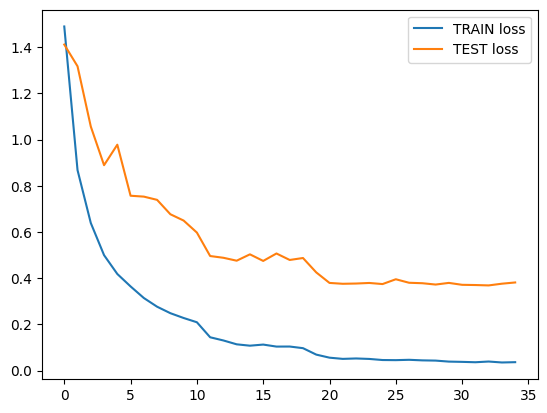

In [103]:
    
X = np.arange(len(train_losses))    
Y = train_losses
    
    
plt.plot(X, train_losses, label='TRAIN loss')
plt.plot(X, test_losses, label='TEST loss')
plt.legend()


plt.savefig('model_losses_finale.png')
plt.show()

## Final Considerations

The project successfully demonstrated the potential of CNNs in automating the identification process and contributing to cetacean research and conservation. Despite the challenges faced, the trained CNN model showcased commendable performance in distinguishing between different cetacean species. Consequently, through the practical application of the knowledge acquired during the course of this study, we successfully adapted our expertise to a field that impassions us greatly. This endeavor allowed us to realize the transformative effects of deploying general knowledge within a domain of personal interest, thereby fostering an elevated level of engagement and dedication to our academic pursuits. It instilled in us an unwavering enthusiasm to continuously raise the bar and strive towards the attainment of our goals.